In [68]:
import os
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from PIL import Image
import copy
import tensorflow as tf
import numpy as np

In [69]:
os.getcwd()
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\style_transfer')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\style_transfer'

## Content Image

Content image shape:
(300, 300, 3)
Content Image:


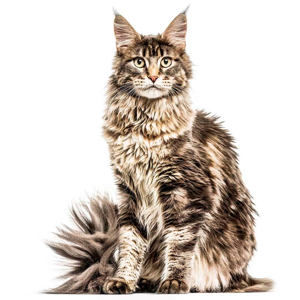

In [70]:
#content image

#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

content_image = Image.open('Maine-Coon-Cat.webp')
aspect_ratio = np.array(content_image).shape[0]/np.array(content_image).shape[1]
content_image = content_image.resize((300, int(300*aspect_ratio)))
print('Content image shape:')
print(np.array(content_image).shape)
print('Content Image:')
content_image
#[Purina](https://www.purina.co.uk/find-a-pet/cat-breeds/maine-coon)

In [71]:
#content image formatting 
print('Content image formatting:')
print(f'Original size: {content_image.size}')

#converting to tensor
content_image = np.array(content_image)/255
content_image = content_image[None,:,:,:]
print((f'Tensor size: {content_image.shape}'))

Content image formatting:
Original size: (300, 300)
Tensor size: (1, 300, 300, 3)


## Style Image

In [72]:
style_image = Image.open('bob-ross.webp')

print('Style image formatting:')
print(f'Original size: {style_image.size}')

#resizing, preserving aspect ratio
style_image = style_image.resize((int(320*1024/791),320))
#print(f'Size after resizing: {style_image.size}')

#cropping
style_image = style_image.crop((10,10,310,310)) #left, upper, right, lower
print(f'Size after cropping: {style_image.size}')

#converting to tensor
style_image = np.array(style_image)/255
style_image = style_image[None,:,:,:]
print((f'Tensor size: {style_image.shape}'))

Style image formatting:
Original size: (1024, 791)
Size after cropping: (300, 300)
Tensor size: (1, 300, 300, 3)


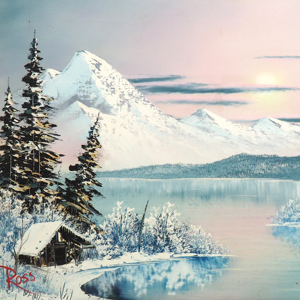

In [73]:
#visualizing adjusted style image 

def show_tensor(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8) 
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

#[Bob ross painting](https://modernartifact.com/products/bob-ross-rare-signed-original-arctic-winter-day-18-x-24-oil-on-canvas-painting#gallery-1)
show_tensor(style_image)

## Loading VGG Neural Network

In [74]:
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(content_image.shape[1], content_image.shape[2], 3),
                                  weights='imagenet')
vgg.trainable = False

for layer in vgg.layers:
    print('name:',layer.name, 'type:',layer)

name: input_8 type: <keras.engine.input_layer.InputLayer object at 0x000001E1037DEA40>
name: block1_conv1 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E1037DE410>
name: block1_conv2 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E15D458EE0>
name: block1_pool type: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001E120EBD5D0>
name: block2_conv1 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E1037F8670>
name: block2_conv2 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E120EBEF50>
name: block2_pool type: <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001E120EBFF70>
name: block3_conv1 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E120EBEC50>
name: block3_conv2 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E120F04EE0>
name: block3_conv3 type: <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E120EBECE0>
name: block3_conv4 type: <ke

In [75]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [76]:
content_layer = [('block5_conv4', 1)]

In [77]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [78]:

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

## Cost functions

In [79]:
# compute content cost using a_C and a_G
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    #a_G dimensions
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #reshape
    a_C_unrolled = tf.reshape(a_C, shape = [_,-1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [_, -1, n_C])
    
    #cost 
    J_content = tf.reduce_sum((a_C-a_G)**2/(4*n_H*n_W*n_C))
    
    return J_content

In [80]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape()
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W,n_C]))
    
    GS = tf.matmul(a_S, tf.transpose(a_S))
    GG = tf.matmul(a_G, tf.transpose(a_G))
    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*n_C**2*((n_H*n_W)**2))
    
    return J_style_layer

In [81]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    J_style = 0
    
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

## Defining initial generated image

In [82]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [83]:
def clip_me(image):
    return tf.clip_by_value(image, 0.0, 1.0)

Checking size of generated image: (1, 300, 300, 3)


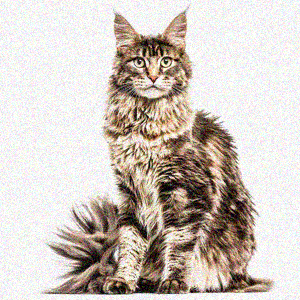

In [84]:
#initialize image to be geenrated 
#generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(content_image),-.15,.15)
generated_image = content_image + noise
generated_image = clip_me(generated_image)
generated_image = tf.Variable(generated_image)
print(f'Checking size of generated image: {generated_image.get_shape()}')

starting_point = copy.deepcopy(generated_image)
image_check = show_tensor(generated_image)
display(image_check)

## Minimizing Cost Function

In [85]:
#alpha_beta is the #ratio of alpha (content) to beta (style)
@tf.function()
def total_cost(J_content, J_style, alpha_beta):
    J = tf.math.multiply(alpha_beta,J_content)+J_style
    return J

In [86]:
learning_rate = 0.01
content_layer = [('block3_conv4', 1)]
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function()
def train_step(generated_image, alpha_beta):

    with tf.GradientTape() as tape:
        a_C = vgg_model_outputs(preprocessed_content)
        a_G = vgg_model_outputs(generated_image)

        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style, alpha_beta)
          
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    
    generated_image.assign(clip_me(generated_image))   
    return J

<h2>Hyperparamter tunning</h2>
<h3>Style to Cost Cost Function Ratio</h3>

In [87]:
import copy

def train(epochs, alpha_beta):
    #defines new starting point for each training session
    #to pick up from last genrated image, comment out
    generated_image = copy.deepcopy(starting_point)
    #display(show_tensor(generated_image))

    epoch_show = 2*int(epochs/10)
    img_log = []
    epoch_list = []

    alpha_beta = np.array(alpha_beta,dtype=np.float32)

    print('Training...')
    for i in range(epochs+1):
        train_step(generated_image, alpha_beta)
        if i % epoch_show == 0:
            print(f'Epoch {i} - Done')
            img = show_tensor(generated_image)
            #display(img.resize((100,100)))
            img_log.append(generated_image)
            epoch_list.append(i)

    #display in grid
    print('Image training progression:')
    for i, image in enumerate(img_log):
        plt.subplot(int(len(img_log)/int(len(img_log)/2)), int(len(img_log)/2), i + 1)
        plt.imshow(show_tensor(image))
        plt.title(str(epoch_list[i]))
        plt.axis('off')
    plt.show()

    #return image from last traiing epoch
    return(generated_image)

Alpha to beta ratio: 0.1
Training...


Epoch 0 - Done
Epoch 200 - Done
Epoch 400 - Done
Epoch 600 - Done
Epoch 800 - Done
Epoch 1000 - Done
Image training progression:


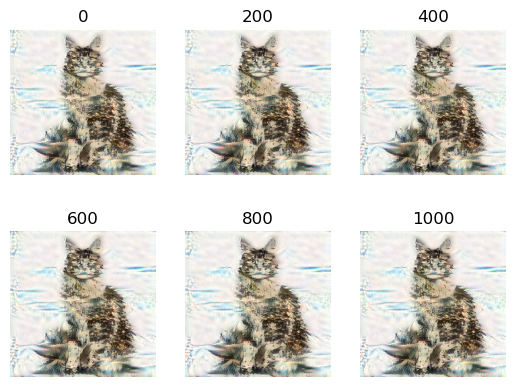

Alpha to beta ratio: 1.0
Training...
Epoch 0 - Done
Epoch 200 - Done
Epoch 400 - Done
Epoch 600 - Done
Epoch 800 - Done
Epoch 1000 - Done
Image training progression:


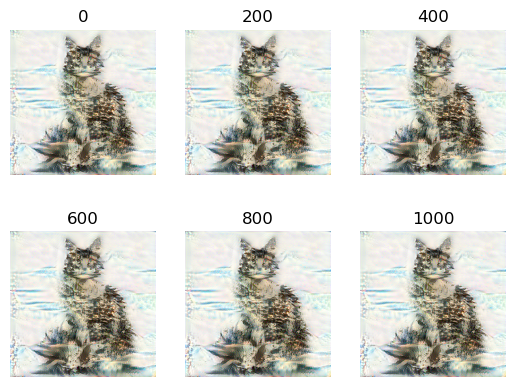

Alpha to beta ratio: 10.0
Training...
Epoch 0 - Done
Epoch 200 - Done
Epoch 400 - Done
Epoch 600 - Done
Epoch 800 - Done
Epoch 1000 - Done
Image training progression:


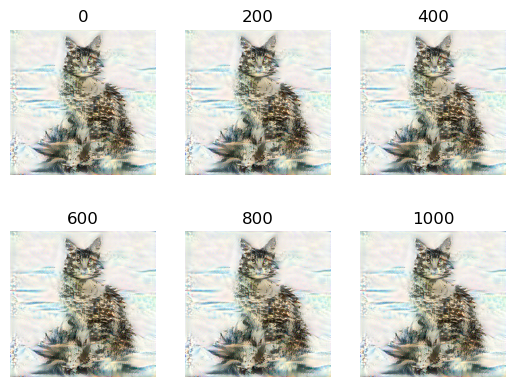

Alpha to beta ratio: 100.0
Training...
Epoch 0 - Done
Epoch 200 - Done
Epoch 400 - Done
Epoch 600 - Done
Epoch 800 - Done
Epoch 1000 - Done
Image training progression:


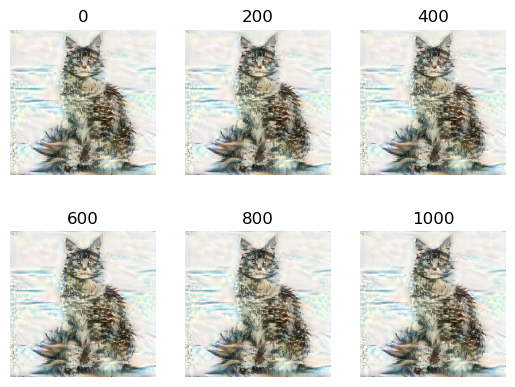

In [88]:
alpha_beta_range = np.array([.1, 1, 10, 100],dtype=np.float32)
epochs = 1000
optimizer.learning_rate = 0.01
image_log = []
content_layer = [('block3_conv4', 1)]

for ratio in alpha_beta_range: 
    print('Alpha to beta ratio:',str(ratio))  
    #print('Starting point')
    #display(show_tensor(starting_point).resize(((100,100))))  
    img = train(epochs, ratio)
    image_log.append(img)


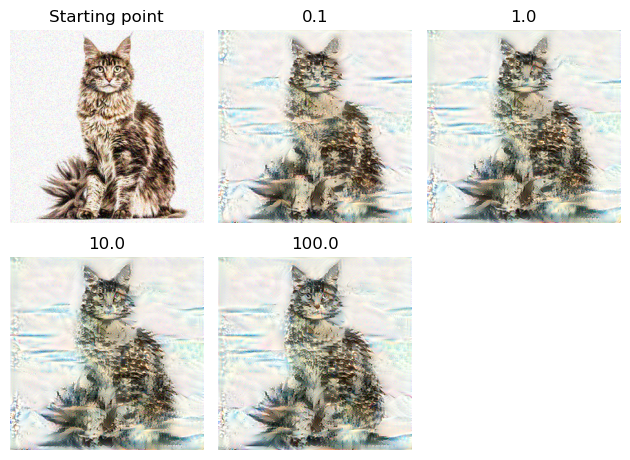

In [89]:
#results of ratio fit 
rows = int(np.ceil(len(image_log)/2+1))
plt.subplot(2,rows,1)
plt.title('Starting point')
plt.imshow(show_tensor(starting_point))
plt.axis('off')

for i, image in enumerate(image_log):
    plt.subplot(2,rows,i+2)
    plt.title(alpha_beta_range[i])
    plt.imshow(show_tensor(image))
    plt.axis('off')

plt.tight_layout()

alpha_beta of 10 selected.

In [90]:
alpha_beta = 10

## VGG Layer Selection

In [91]:
CONTENT_LAYERS = [
    ('block3_conv4', 1),
    ('block4_conv4', 1),
    ('block5_conv4', 1)]

('BLOCK3_CONV4', 1)
Training...


Epoch 0 - Done
Epoch 20 - Done
Epoch 40 - Done
Epoch 60 - Done
Epoch 80 - Done
Epoch 100 - Done
Image training progression:


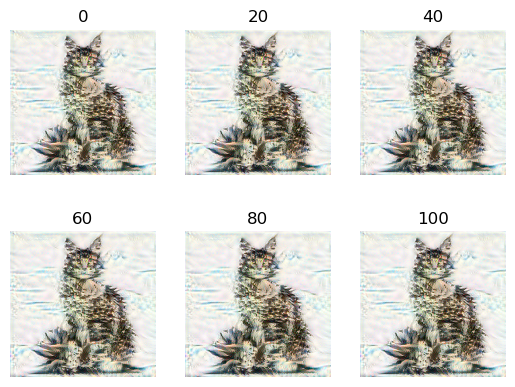

('BLOCK4_CONV4', 1)
Training...
Epoch 0 - Done
Epoch 20 - Done
Epoch 40 - Done
Epoch 60 - Done
Epoch 80 - Done
Epoch 100 - Done
Image training progression:


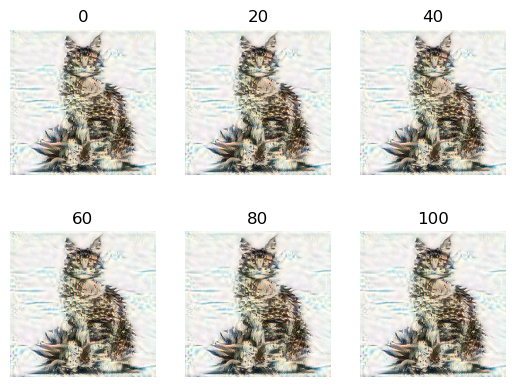

('BLOCK5_CONV4', 1)
Training...
Epoch 0 - Done
Epoch 20 - Done
Epoch 40 - Done
Epoch 60 - Done
Epoch 80 - Done
Epoch 100 - Done
Image training progression:


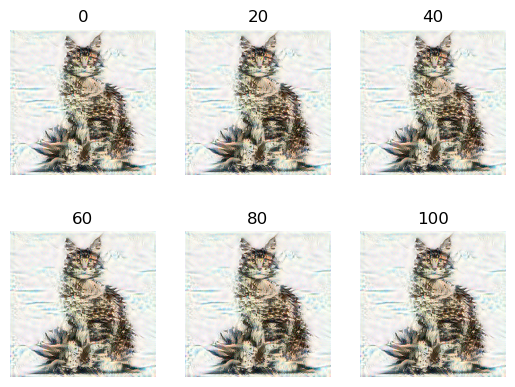

In [92]:
img_log = []
epochs = 100
optimizer.learning_rate = .01

for i,layer in enumerate(CONTENT_LAYERS):
    content_layer = [CONTENT_LAYERS[i]]
    vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)
    #print(vgg_model_outputs.outputs[-1])
    print(str(content_layer[0]).upper())
    img = train(epochs, alpha_beta)
    img_log.append(img)

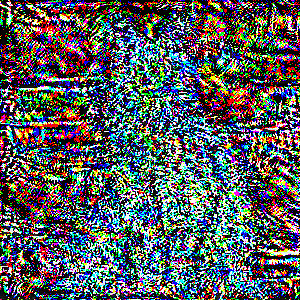

In [93]:
#Checking that there is indeed a difference
show_tensor(img_log[2]-img_log[0])

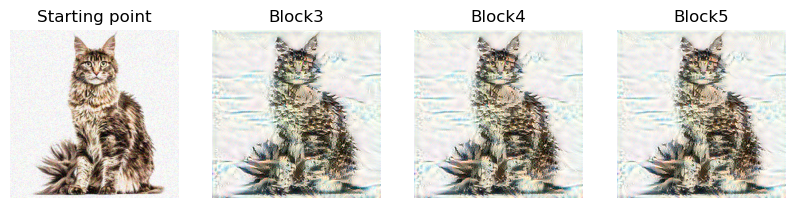

In [94]:
#results of ratio fit 
plt.figure(figsize=(10,8))
plt.subplot(1,len(img_log)+1,1)
plt.title('Starting point')
plt.imshow(show_tensor(starting_point))
plt.axis('off')

for i, image in enumerate(img_log):
    plt.subplot(1,len(img_log)+1,i+2)
    plt.title(str(CONTENT_LAYERS[i][0].title()[:6]))
    plt.imshow(show_tensor(image))
    plt.axis('off')

Training...


Epoch 0 - Done
Epoch 2000 - Done
Epoch 4000 - Done
Epoch 6000 - Done
Epoch 8000 - Done
Epoch 10000 - Done
Image training progression:


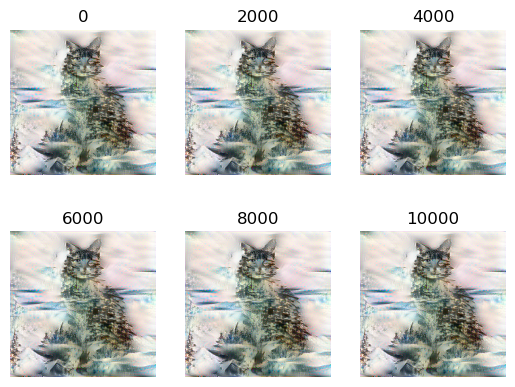

In [95]:
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + [('block5_conv4', 1)])
optimizer.learning_rate = 0.01
epochs = 10000
final_image = train(epochs, alpha_beta)

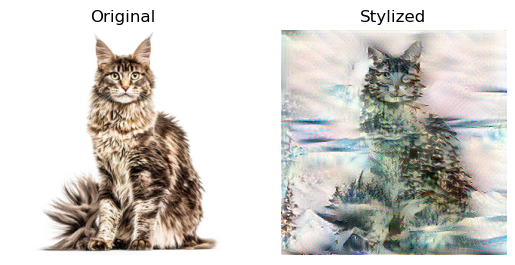

In [96]:
plt.subplot(1,2,1)
plt.imshow(show_tensor(content_image))
plt.axis('off')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(show_tensor(final_image))
plt.axis('off')
plt.title('Stylized')
plt.show()